# **Moduł treningu sieci konwolucyjnej**

## Przygotowanie bibliotek i narzędzi

### Import potrzebnych bibliotek do treningu

Trening zostanie wykonany w oparciu o bibliotekę *tensorflow* oraz *keras*. Wyświetlanie statystyk zrealizowano przy pomocy biblioteki *matplotlib*.

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Softmax, Input, BatchNormalization
from tensorflow.keras import Model

import random
import matplotlib.pyplot as plt
import numpy as np
import os

from IPython.display import clear_output

### Uruchomienie TPU

Krok ten nie jest wymagany, jednak rekomendowany jeśli jest taka możliwość. Użycie TPU znacząco skraca czas trwania przeprowadzanego treningu.

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.7.0
Running on TPU  ['10.113.219.66:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.113.219.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.113.219.66:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Łączenie z dyskiem google drive

Użycie dysku w podany poniżej sposób jest tylko możliwe podczas korzystania z Google Colaba. 

**Wymagana akcja użytkownika!**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive"

 best_mnist.h5	    DomkaMNISTDomka.zip   mnist_v2.h5   results
 BestMnist.zip	    mnist_98.h5		  models        test_data
'Colab Notebooks'   mnist_noau.h5	  MyMnist.zip


## Przygotowanie do treningu

### Parametry do treningu

Ta komórka zawiera parametry możliwe do modyfikacji przez użytkownika. Należą do nich:

1.   BATCH_SIZE - rozmiar podzbiorów zbioru treningowego powstałych w wyniku podziału,
2.   EPOCHS - liczba iteracji zbioru trenigowego przez sieć,
3.   IMG_SIZE - rozmiar obrazu wejściowego sieci (testowano na rozmiarze max 227x227).



In [ ]:
BATCH_SIZE = 32
EPOCHS = 25
IMG_SIZE = 224
LEARNING_RATE = 0.001

OUTPUT_PATH = "/content/drive/MyDrive/models/"

### Przygotowanie zbioru danych do treningu

Jako zbioru danych użyto prostego zbioru CIFAR 10, składającego się z 60000 różnych zdjęć o wymiarze 32x32 podzielonych na 10 różnych klas, reprezentujących różne obiekty. 

Zbiór podzielono na 3 części:

*   zbiór treningowy - 42 tys. zdjęć,
*   zbiór walidacyjny - 8 tys. zdjęć,
*   zbiór testowy - 10 tys. zdjęć.

Zbiór testowy, walidacyjny i treningowe są od siebie niezależne.



In [ ]:
(train_set, train_labels), (test_set, test_labels) = datasets.cifar10.load_data()
validation_set, validation_labels = train_set[:8000], train_labels[:8000]
train_set, train_labels = train_set[8000:], train_labels[8000:]

print(train_set[0].shape)

(32, 32, 3)


### Normalizacja i augmentacja



Augmentacja składa się z losowego odbicia pionowego i poziomego.

In [ ]:
augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)                          
])

In [ ]:
def standardization(image):
  # Normalize images to have a mean of 0 and standard deviation of 1
  image = tf.image.per_image_standardization(image)
  return image

In [ ]:
def augment_dataset(dataset):
  return dataset.map(lambda x, y: (augmentation(x), y)) 

In [ ]:
def prepare_datasets():
  size = len(train_set) // 5
  train_ds = tf.data.Dataset.from_tensor_slices((train_set, train_labels))
  test_ds = tf.data.Dataset.from_tensor_slices((test_set, test_labels))
  validation_ds = tf.data.Dataset.from_tensor_slices((validation_set, validation_labels))

  train_ds = (train_ds.map(lambda x, y: (standardization(x), y))
                  .shuffle(size)
                  .batch(batch_size=BATCH_SIZE, drop_remainder=True))
  test_ds = (test_ds.map(lambda x, y: (standardization(x), y))
                    .batch(batch_size=BATCH_SIZE, drop_remainder=True))
  validation_ds = (validation_ds.map(lambda x, y: (standardization(x), y))
                    .shuffle(size)
                    .batch(batch_size=BATCH_SIZE, drop_remainder=True))
  
  return train_ds, test_ds, validation_ds
    

### Przygotowanie modelu

Poniżej przedstawiono dwie propozycje modeli:

*   model sieci bazujący na architekturze zaproponowanej przez autora - *myConv*,
*   model sieci bazujący na architekturze *AlexNet*.



Istnieje możliwość dodania własnego modelu. W tym celu należy stworzyć nową komórkę z kodem i zdefiniować tam funkcję zwracającą nowy model. Istnieje jedno ograniczenie, zaprojektowana sieć musi zawierać warstwę, w której automatycznie zostanie dokonana modyfikacja rozmiaru zdjęcia na co najmniej 224x224 (warstwa *preprocess*).

In [ ]:
def get_myConv():
  # myNet
  model = tf.keras.models.Sequential(name="MyOwnConv")
  input = Input(shape=(None, None, 3))
  preprocess = tf.keras.layers.Resizing(224, 224, interpolation="bilinear", crop_to_aspect_ratio=False)
  conv1 = Conv2D(224, (5,5), strides=(3,3), activation="relu", name="conv1")
  pool1 = MaxPooling2D((2, 2), strides=(2,2), name="pool1")
  conv2 = Conv2D(122, (3,3), activation="relu", name="conv2")
  pool2 = MaxPooling2D((5, 5), strides=(2,2), padding="same", name="pool2")
  conv3 = Conv2D(56, (3,3), activation="relu", name="conv3")
  conv4 = Conv2D(28, (5,5), activation="relu", name="conv4")
  pool3 = MaxPooling2D((2, 2), strides=(2,2), name="pool4")
  flatten = Flatten()
  dense1 = Dense(64, activation="relu")
  drop1 = Dropout(0.25)
  dense2 = Dense(10, activation="softmax")

  model.add(input)
  model.add(preprocess)
  model.add(conv1)
  model.add(pool1)
  model.add(conv2)
  model.add(pool2)
  model.add(conv3)
  model.add(conv4)
  model.add(pool3)
  model.add(flatten)
  model.add(dense1)
  model.add(drop1)
  model.add(dense2)

  return model

In [ ]:
def get_alexNet():
  # alexNet
  model = tf.keras.models.Sequential(name="MyConv")
  input = Input(shape=(None, None, 3))
  preprocess = tf.keras.layers.Resizing(227, 227, interpolation="bilinear", crop_to_aspect_ratio=False)
  conv1 = Conv2D(filters=96, kernel_size=(11,11), strides=(4, 4), activation="relu", name="conv1")
  bad_batch1 = BatchNormalization()
  pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name="pool1")
  conv2 = Conv2D(filters=256, kernel_size=(5,5), padding="same", activation="relu", name="conv2")
  bad_batch2 = BatchNormalization()
  pool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name="pool2")
  conv3 = Conv2D(filters=384, kernel_size=(3,3), activation='relu', padding="same", name="conv3")
  bad_batch3 = BatchNormalization()
  conv4 = Conv2D(filters=384, kernel_size=(3,3), activation='relu', padding="same", name="conv4")
  bad_batch4 = BatchNormalization()
  conv5 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding="same", name="conv5")
  bad_batch5 = BatchNormalization()
  pool3 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), name="pool3")
  flatten = Flatten()
  dense1 = Dense(4096, activation='relu')
  drop1 = Dropout(0.5)
  dense2 = Dense(4096, activation='relu')
  drop2 = Dropout(0.5)
  output = Dense(10, activation='softmax')

  model.add(input)
  model.add(preprocess)
  model.add(conv1)
  model.add(bad_batch1)
  model.add(pool1)
  model.add(conv2)
  model.add(bad_batch2)
  model.add(pool2)
  model.add(conv3)
  model.add(bad_batch3)
  model.add(conv4)
  model.add(bad_batch4)
  model.add(conv5)
  model.add(bad_batch5)
  model.add(pool3)
  model.add(flatten)
  model.add(dense1)
  model.add(drop1)
  model.add(dense2)
  model.add(drop2)
  model.add(output)
  

  return model

Gdy dodany zostanie nowy model, należy dodać go jako kolejną opcję w poniższym *if-ie*.

In [ ]:
def get_model(option="alexNet"):
  if option == "alexNet":
    return get_alexNet()
  elif option == "myConv":
    return get_myConv()
  else:
    raise Exception(f"Invalid network {option}")

## Trening

Uruchomienie treningu wiąże się z wywołaniem funkcji *train*. Jej zadaniem jest przeprowadzenie treningu, zapis wytrenowanego modelu i wyświetlenie statystyk.

Funckję *train* można wywołać z następującymi parametrami:

*   *model* (wymagany) - model który zostanie użyty w treningu, bazowo dostępne są "myConv" oraz "alexNet",
*   *optimizer* (opcjonalnie) - optymalizator używany w procesie uczenia, dostępne "SGD" oraz "ADAM". (domyślnie SGD),
*   *augmentation* (opcjonalnie) - augmentacja zbioru treningowego (domyślnie FALSE),
*   *is_tpu* (opcjonalnie) - czy trening ma się odbywać w środowisku TPU (domyślnie TRUE).



In [ ]:
def save_model(model_name, accuracy, model, augmentation):
  accuracy = int(accuracy * 100)
  print(f"Saving model with accuracy: {accuracy}%")
  path = os.path.join(OUTPUT_PATH, f"{model_name}_{accuracy}_aug_{augmentation}.h5")
  model.save(path)

In [ ]:
def show_results(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')

In [ ]:
def train(model_name, optimizer="SGD", augmentation=False, is_tpu=True):
  """ Run trainng, save model and show statistics

  :param model_name: Model, options: myConv, alexNet
  :type model_name: str
  :param optimizer: Optimizer, options: ADAM, SGD, default: SGD
  :type optimizer: str
  :param augmentation: Run data augmentation, default: False
  :type augmentation: bool
  :param is_tpu: Run on TPU, default: True
  :type is_tpu: bool
  
  """

  train_ds, test_ds, validation_ds = prepare_datasets()

  if augmentation:
    train_ds = augment_dataset(train_ds)

  if optimizer == "SGD":
    opt = tf.optimizers.SGD(LEARNING_RATE)
  elif optimizer == "ADAM":
    opt = tf.optimizers.Adam(LEARNING_RATE, beta_1=0.99, epsilon=1e-1)
  else:
    raise Exception("Invalid optimizer!")

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

  if is_tpu:
    with tpu_strategy.scope():
      model = get_model(option=model_name)
      model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])
    model.summary()
  else:
    model = get_model(option=model_name)
    model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])
    model.summary()

  history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds)

  evaluation = model.evaluate(test_ds)
  print(f"Model evaluation: {evaluation}")

  curr_acc = history.history["accuracy"][-1]
  save_model(model_name, curr_acc, model, augmentation)

  show_results(history)

  return model

Model: "MyConv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_9 (Resizing)       (None, 227, 227, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_45 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 pool1 (MaxPooling2D)        (None, 27, 27, 96)        0         
                                                                 
 conv2 (Conv2D)              (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_46 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                           

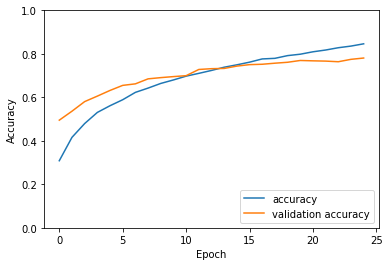

In [ ]:
model = train("alexNet")

# Testowanie wytrenowanego modelu - predykcja


W poniższej komórce znajdują się wszystkie możliwe klasy zbioru CIFAR-10.

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
def random_img_prediction():
  """ Make prediction on random image from test_set """
  index = random.randint(0, len(test_set)-1)
  probability = model(test_set[index:index+1])
  best = probability.numpy().max()
  x = np.where(probability == best)

  plt.title(f"{class_names[x[1][0]]} : {best}")
  plt.imshow(test_set[index])

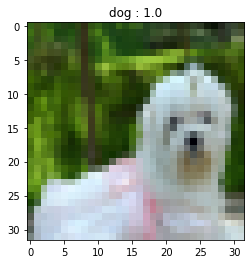

In [ ]:
random_img_prediction()

## Bibliografia



1.   https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
2.   https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
